<a href="https://colab.research.google.com/github/michellbrito/CSCE_614_Term_Project/blob/main/CSCE_614_CNN_for_MNIST_CPU%2C_GPU%2C_No_Acceleration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Packages that may need to be installed

In [ ]:
!pip install hyperopt

In [ ]:
!pip install --upgrade wandb
!wandb login 6508adb8701b189506a5541448dfc6f1e805edeb

Requirement already up-to-date: wandb in /usr/local/lib/python3.6/dist-packages (0.10.11)
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#install only if trying to run on local NVIDIA GPU with CUDA cores enabled
!pip install tensorflow-gpu

#Libraries

In [2]:
#basics
from math import floor, sqrt, pi
from random import sample
import time
import timeit
#helpful progress bar
from tqdm.notebook import tqdm, trange

import warnings
warnings.filterwarnings("ignore")
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical

from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
import warnings
warnings.filterwarnings("ignore")  # Ignore some warning logs
from keras.models import Sequential

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from sklearn.model_selection import cross_validate, train_test_split

import os


#Measuring Metrics
1) run the code below
2) click on the link
3) sign up if you need to
4) copy the code it gives you
5) paste it here
6) go back to the website, go to metrics. You will be able to see the metrics from there.

In [ ]:
#This will initialize wandb for measuring metrics and write all metrics to csce614 project
import wandb
from wandb.keras import WandbCallback
wandb.init(project="csce614")

epoch,14
loss,0.15506
accuracy,0.95003
_step,14
_runtime,108
_timestamp,1606534580


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▆▆▇▇▇▇████████
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
_runtime,▁▂▂▂▃▄▄▄▅▅▆▆▇▇█
_timestamp,▁▂▂▂▃▄▄▄▅▅▆▆▇▇█


#Checking Current Hardware Specs

GPU Information:

In [3]:
!nvidia-smi

Fri Dec  4 00:14:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    30W /  70W |    227MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

CPU Information:

In [4]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

#Loading the MNIST dataset

11493376/11490434 [==============================] - 0s 0us/step
Train Image Shape:  (60000, 28, 28) Train Label Shape:  (60000,)
Test Image Shape:  (10000, 28, 28) Test Label Shape:  (10000,)
Visualizing a random image (11th) from training dataset


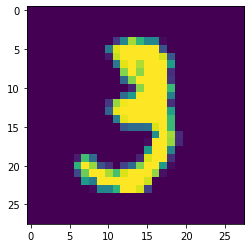

In [ ]:
 #Load MNISt dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Check number of samples (60000 in training and 10000 in test)
# Each image has 28 x 28 pixels
print("Train Image Shape: ", train_images.shape, "Train Label Shape: ", train_labels.shape) 
print("Test Image Shape: ", test_images.shape, "Test Label Shape: ", test_labels.shape) 

#  Visualizing a random image (11th) from training dataset
print("Visualizing a random image (11th) from training dataset")
_ = plt.imshow(train_images[10])

#Preprocessing and reshaping

In [ ]:
# Preprocessing: Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

In [ ]:
train_images_3d = train_images.reshape(60000,28,28,1)
test_images_3d = test_images.reshape(10000,28,28,1)
print(train_images_3d.shape, test_images_3d.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


#CNN Neural Network with unoptimized hyperparameters

In [ ]:
model = Sequential([Conv2D(50, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu', input_shape=(28,28,1)), 
          Conv2D(75, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu'), 
          MaxPooling2D(pool_size=(2,2)), Dropout(0.25),
          Conv2D(125, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu'),
          MaxPooling2D(pool_size=(2,2)), Dropout(0.25), 
          Flatten(),
          Dense(500, activation='relu'), Dropout(0.4),
          Dense(250, activation='relu'), Dropout(0.3),
          Dense(10, activation='softmax')])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 50)        100       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 75)        3825      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 75)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 125)       9500      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 125)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 125)        

In [ ]:
#Training the network without optimized hyperparameters
import time 
start_time = time.time()
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs
model.fit(train_images_3d, to_categorical(train_labels), epochs=15, batch_size=128,callbacks=[WandbCallback()],)
model.save(os.path.join(wandb.run.dir, "model.h5"))


print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/15
469/469 [==============================] - 5s 10ms/step - loss: 0.5608 - accuracy: 0.8176
Epoch 2/15
469/469 [==============================] - 5s 10ms/step - loss: 0.2891 - accuracy: 0.9079
Epoch 3/15
469/469 [==============================] - 5s 10ms/step - loss: 0.2419 - accuracy: 0.9232
Epoch 4/15
469/469 [==============================] - 5s 10ms/step - loss: 0.2180 - accuracy: 0.9313
Epoch 5/15
469/469 [==============================] - 5s 10ms/step - loss: 0.2030 - accuracy: 0.9344
Epoch 6/15
469/469 [==============================] - 5s 10ms/step - loss: 0.1943 - accuracy: 0.9375
Epoch 7/15
469/469 [==============================] - 5s 10ms/step - loss: 0.1803 - accuracy: 0.9421
Epoch 8/15
469/469 [==============================] - 5s 10ms/step - loss: 0.1786 - accuracy: 0.9418
Epoch 9/15
469/469 [==============================] - 5s 10ms/step - loss: 0.1713 - accuracy: 0.9452
Epoch 10/15
469/469 [==============================] - 5s 10ms/step - loss: 0.1629 - accura

In [ ]:
performance = model.evaluate(test_images_3d, to_categorical(test_labels))
print("Accuracy on Test samples: {0}".format(performance[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.1728 - accuracy: 0.9541
Accuracy on Test samples: 0.9541000127792358


#HyperOpt: Optimizing hyperparameters

A function that uses Hyperopt to automatically take the CNN hyperparameters, alter them, and pick the best set of hyperparameter combinations

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


def optimize_cnn(hyperparameter):
  
  # Define model using hyperparameters 

  cnn_model = Sequential([Conv2D(50, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], padding='same', activation=hyperparameter['activation'], input_shape=(28,28,1)), 
          Conv2D(75, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], padding='same', activation=hyperparameter['activation']), 
          MaxPooling2D(pool_size=(2,2)), Dropout(hyperparameter['dropout_prob']),
          Conv2D(125, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], padding='same', activation=hyperparameter['activation']),
          MaxPooling2D(pool_size=(2,2)), Dropout(hyperparameter['dropout_prob']), 
          Flatten(),
          Dense(500, activation='relu'), Dropout(0.4),
          Dense(250, activation='relu'), Dropout(0.3),
          Dense(10, activation='softmax')])
  
  cnn_model.compile(optimizer=hyperparameter['optimizer'], loss='categorical_crossentropy', metrics=['accuracy'],)

  # create a training (50K samples) and validation (10K samples) subsets from training images.
  # Validation subset will be used to find the optimal hyperparameters
  train_X, train_y = train_images_3d[:50000], train_labels[:50000]
  valid_X, valid_y = train_images_3d[50000:], train_labels[50000:]

  _ = cnn_model.fit(train_X, to_categorical(train_y), epochs=2, batch_size=128, verbose=0)
  # Evaluate accuracy on validation data
  performance = cnn_model.evaluate(valid_X, to_categorical(valid_y), verbose=0)

  print("Hyperparameters: ", hyperparameter, "Accuracy: ", performance[1])
  print("----------------------------------------------------")
  # We want to minimize loss i.e. negative of accuracy
  return({"status": STATUS_OK, "loss": -1*performance[1], "model":cnn_model})
  

# Define search space for hyper-parameters
space = {
    # The kernel_size for convolutions:
    'conv_kernel_size': hp.choice('conv_kernel_size', [1, 3, 5]),
    # Uniform distribution in finding appropriate dropout values
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.35),
    #choice of stride
    'conv_stride': hp.choice('conv_stride',[1,2]),
    #choice of activation
    'activation': hp.choice('activation', ['relu','selu','tanh']),
    # Choice of optimizer 
    'optimizer': hp.choice('optimizer', ['Adam', 'sgd']),
}

trials = Trials()

# Find the best hyperparameters
best = fmin(
        optimize_cnn,
        space,
        algo=tpe.suggest,
        trials=trials,
        max_evals=25,
    )

print("==================================")
print("Best Hyperparameters", best)

# You can retrain the final model with optimal hyperparameters on train+validation data

# Or you can use the model returned directly
# Find trial which has minimum loss value and use that model to perform evaluation on the test data
test_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

performance = test_model.evaluate(test_images_3d, to_categorical(test_labels))

print("==================================")
print("Test Accuracy: ", performance[1])

Hyperparameters: 
{'activation': 'selu', 'conv_kernel_size': 1, 'conv_stride': 2, 'dropout_prob': 0.30563575033128176, 'optimizer': 'sgd'}
Accuracy: 
0.1665000021457672
----------------------------------------------------
Hyperparameters: 
{'activation': 'tanh', 'conv_kernel_size': 3, 'conv_stride': 2, 'dropout_prob': 0.12869068811893428, 'optimizer': 'sgd'}
Accuracy: 
0.4318999946117401
----------------------------------------------------
Hyperparameters: 
{'activation': 'selu', 'conv_kernel_size': 5, 'conv_stride': 2, 'dropout_prob': 0.34092122970047456, 'optimizer': 'Adam'}
Accuracy: 
0.9814000129699707
----------------------------------------------------
Hyperparameters: 
{'activation': 'relu', 'conv_kernel_size': 5, 'conv_stride': 2, 'dropout_prob': 0.1788426252439586, 'optimizer': 'Adam'}
Accuracy: 
0.98089998960495
----------------------------------------------------
Hyperparameters: 
{'activation': 'selu', 'conv_kernel_size': 1, 'conv_stride': 2, 'dropout_prob': 0.2330746868404

#Model with optimized Hyperparameters

In [ ]:
model = Sequential([Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(28,28,1)), 
          Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'), 
          MaxPooling2D(pool_size=(2,2)), Dropout(0.2538798802417247),
          Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
          MaxPooling2D(pool_size=(2,2)), Dropout(0.2538798802417247), 
          Flatten(),
          Dense(500, activation='relu'), Dropout(0.4),
          Dense(250, activation='relu'), Dropout(0.3),
          Dense(10, activation='softmax')])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 50)        500       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 75)        33825     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 75)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 125)       84500     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 125)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 125)        

In [ ]:
import time 
start_time = time.time()
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs
model.fit(train_images_3d, to_categorical(train_labels), epochs=15, batch_size=128,callbacks=[WandbCallback()],)
model.save(os.path.join(wandb.run.dir, "model.h5"))


print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/15
469/469 [==============================] - 7s 15ms/step - loss: 0.2077 - accuracy: 0.9329
Epoch 2/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0598 - accuracy: 0.9830
Epoch 3/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0409 - accuracy: 0.9877
Epoch 4/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0380 - accuracy: 0.9886
Epoch 5/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0318 - accuracy: 0.9902
Epoch 6/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0260 - accuracy: 0.9922
Epoch 7/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0227 - accuracy: 0.9929
Epoch 8/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0223 - accuracy: 0.9936
Epoch 9/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0185 - accuracy: 0.9948
Epoch 10/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0187 - accura

In [ ]:
performance = model.evaluate(test_images_3d, to_categorical(test_labels))
print("Accuracy on Test samples: {0}".format(performance[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.0194 - accuracy: 0.9950
Accuracy on Test samples: 0.9950000047683716


In [ ]:
wandb.run.finish()

epoch,14
loss,0.01388
accuracy,0.99592
_step,29
_runtime,390
_timestamp,1606536201


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇█████████████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
